# Setup

In [1]:
import importlib

# import hvplot.pandas  # noqa
import ipywidgets as widgets
import numpy as np
import pandas as pd
# import panel as pn
# import panel.widgets as pnw
import plotly.express as px
from IPython.display import display
import re
from plotnine import *
import matplotlib.pyplot as plt

from db_functions import string_to_numeric_or_timedelta, fetch_filtered_run_uuids, fetch_distinct_tag_values, \
    query_to_df
import key_mapping
import value_mapping
importlib.reload(key_mapping)
importlib.reload(value_mapping)
key_mapping = key_mapping.key_mapping
value_mapping = value_mapping.value_mapping

# hvplot.extension('plotly')
fig_dir = "../data/figures"

updating value_mapping...
updating value_mapping...


In [2]:
def add_grouped_mean_columns(df, pattern=r'^(.*?)_(\d+)$', mean_suffix='__mean', inplace=False):
    """
    Identifies groups of columns in a DataFrame based on a regex pattern
    (typically 'prefix_number') and adds new columns containing the row-wise
    mean for each identified group.

    Args:
        df (pd.DataFrame): The input DataFrame.
        pattern (str, optional): The regex pattern used to identify columns
                                 and capture the prefix. Must capture the
                                 prefix as group 1.
                                 Defaults to r'^(.*?)_(\d+)$'.
        mean_suffix (str, optional): The suffix to append to the prefix for the
                                     new mean column names. Defaults to '_mean'.
        inplace (bool, optional): If True, modify the DataFrame in place and
                                  return None. If False, return a new DataFrame
                                  with the added columns, leaving the original
                                  unchanged. Defaults to False.

    Returns:
        pd.DataFrame or None: Returns a new DataFrame with added mean columns
                              if inplace=False. Returns None if inplace=True.

    Raises:
        TypeError: If the input df is not a pandas DataFrame.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")

    # Step 2: Identify Column Prefixes and group column names
    prefixes_to_cols = {}
    compiled_pattern = re.compile(pattern) # Compile regex for efficiency

    for col in df.columns:
        match = compiled_pattern.match(col)
        if match:
            prefix = match.group(1) # Get the captured prefix (e.g., 'featA')
            if prefix not in prefixes_to_cols:
                prefixes_to_cols[prefix] = []
            prefixes_to_cols[prefix].append(col)

    # Decide whether to modify in place or return a copy
    if inplace:
        output_df = df # Work directly on the input DataFrame
    else:
        output_df = df.copy() # Work on a copy

    print(f"Identified groups: {list(prefixes_to_cols.keys())}") # Optional: Inform user

    # Step 3: Calculate Means and Add New Columns
    for prefix, cols_list in prefixes_to_cols.items():
        if cols_list: # Check if the list is not empty
            mean_col_name = f"{prefix}{mean_suffix}"
            # Calculate mean using the original df's data for columns
            output_df[mean_col_name] = df[cols_list].mean(axis=1, skipna=False) # axis=1 for row-wise mean, don't skip NAs!

    # Return the result based on the inplace argument
    if inplace:
        return None
    else:
        return output_df

In [3]:
def get_multi_carrier_metrics(df, pattern=r'^(.*?)_(\d+)$', inplace=False):
    """
    Identifies groups of columns in a DataFrame based on a regex pattern
    and stacks

    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")

    # Step 2: Identify Column Prefixes and group column names
    prefixes_to_cols = {}
    multi_carrier_columns = []
    compiled_pattern = re.compile(pattern) # Compile regex for efficiency

    for col in df.columns:
        match = compiled_pattern.match(col)
        if match:
            prefix = match.group(1) # Get the captured prefix (e.g., 'featA')
            if prefix not in prefixes_to_cols:
                prefixes_to_cols[prefix] = []
            prefixes_to_cols[prefix].append(col)
            multi_carrier_columns.append(col)

    # Decide whether to modify in place or return a copy
    if inplace:
        output_df = df # Work directly on the input DataFrame
    else:
        output_df = df.copy() # Work on a copy

    # TEMPORARY Step 3: select the columns
    output_df = output_df[['run_uuid'] + multi_carrier_columns]

    output_df = output_df.melt(id_vars='run_uuid')
    output_df[['key', 'carrier']] = output_df['key'].str.rsplit('_', expand=True, n=1)
    # output_df['carrier'] = pd.to_numeric(output_df['carrier'])  #optional
    output_df = output_df[['run_uuid', 'carrier', 'key', 'value']]
    
    # Return the result based on the inplace argument
    if inplace:
        return None
    else:
        return output_df

In [4]:
def complete_steps_fast(df: pd.DataFrame, fill_value=np.nan):
    """
    Efficiently fills in missing steps for multi-step metrics up to the maximum step
    for each key using vectorized operations.
    
    param: df: long dataframe with columns run_uuid, key, value, step
    """
    max_steps_per_key = df.groupby('key')['step'].max()
    # 1. Get all unique run_uuid and key combinations
    run_key_combos = df[['run_uuid', 'key']].drop_duplicates()
    # 2. Create a list of DataFrames, one for each key with its specific max step
    template_dfs = []
    
    for key, max_step in max_steps_per_key.items():
        # Get all runs for this key
        runs_for_key = run_key_combos[run_key_combos['key'] == key]['run_uuid'].unique()
        
        # Create all possible combinations for this key
        key_template = pd.DataFrame({
            'run_uuid': np.repeat(runs_for_key, max_step + 1),
            'key': key,
            'step': np.tile(np.arange(max_step + 1), len(runs_for_key))
        })
        
        template_dfs.append(key_template)
    
    template = pd.concat(template_dfs, ignore_index=True)
    
    # Merge with original data to get values where available
    result = pd.merge(
        template, 
        df, 
        on=['run_uuid', 'key', 'step'], 
        how='left'
    )
    
    # Fill missing values
    result['value'] = result['value'].fillna(fill_value)
    
    return result

In [5]:
def parameters_and_metrics(tag_filters: dict, param_filters: dict):
    """
    get the selected runs' parameters and metrics in a long format table
    """    
    RUN_UUIDS_CACHE = fetch_filtered_run_uuids(tag_filters, param_filters)

    where_condition = ', '.join(map(lambda x: f'\'{x}\'', RUN_UUIDS_CACHE))
    query_runs = f"""
    SELECT
        *
    FROM
        RUNS R
    WHERE R.RUN_UUID IN ({where_condition})
    """
    df_runs = query_to_df(query_runs)

    query_experiments = f"""
    SELECT
        *
    FROM
        EXPERIMENTS
    """
    df_experiments = query_to_df(query_experiments)

    query_tags = f"""
    SELECT
        *
    FROM
        TAGS T
    WHERE RUN_UUID IN ({where_condition})
    """
    df_tags = query_to_df(query_tags)
    df_tags_wide = df_tags.pivot(columns='key', index='run_uuid', values='value')

    query_params = f"""
    SELECT
        *
    FROM
        PARAMS P
    WHERE RUN_UUID IN ({where_condition})
    """
    df_params = query_to_df(query_params)
    # NOTE sometimes, some params are stored multiple times, i.e. as arrays -> keep only the last entry
    df_params.drop_duplicates(subset=['key', 'run_uuid'], keep='last', inplace=True)

    df_params_wide = df_params.pivot(columns='key', index='run_uuid', values='value')

    # merge the dataframes
    PARAMS = pd.merge(df_runs, df_experiments, on='experiment_id')
    PARAMS = pd.merge(PARAMS, df_tags_wide, on='run_uuid')
    PARAMS = pd.merge(PARAMS, df_params_wide, on='run_uuid')

    # replace and rename
    PARAMS = PARAMS.replace(value_mapping)
    PARAMS = PARAMS.rename(columns=key_mapping)
    
    # transform to the correct data types
    PARAMS = string_to_numeric_or_timedelta(PARAMS)
    
    # get the metrics data
    query_metrics = f"""
    SELECT
        *
    FROM
        METRICS M
    WHERE RUN_UUID IN ({where_condition})
    """
    df_metrics = query_to_df(query_metrics)
    df_metrics['timestamp'] = pd.to_datetime(df_metrics['timestamp'], unit='ms')
    df_metrics = complete_steps_fast(df_metrics)
    df_metrics = df_metrics.replace({'value': {np.finfo(np.float64).max: np.inf}})  # replace max floats with proper np.inf
    # pivot to enable replacing and renaming
    METRICS = df_metrics.pivot(columns='key', index=['run_uuid', 'step'], values='value').reset_index()

    # replace and rename
    METRICS = METRICS.replace(value_mapping)
    METRICS = METRICS.rename(columns=key_mapping)

    # transform to the correct data types
    METRICS = string_to_numeric_or_timedelta(METRICS)

    # melt/unpivot to get the long format again
    METRICS = METRICS.melt(id_vars=['run_uuid', 'step'])

    return PARAMS, METRICS

In [6]:
def interactive_search(string_list):
    # Create a Text widget for the search box
    search_box = widgets.Text(
        value='',
        placeholder='Type to search',
        description='Search:',
        disabled=False
    )

    # Create an Output widget to display the filtered list
    output = widgets.Output()

    # Function to filter the list based on the search query
    def filter_list(change):
        search_query = change['new']
        with output:
            output.clear_output()
            filtered_list = [s for s in string_list if search_query.lower() in s.lower()]
            for item in filtered_list:
                print(item)

    # Attach the filter function to the search box
    search_box.observe(filter_list, names='value')

    # Display the search box and output
    display(search_box, output)

In [7]:
def join_columns(df: pd.DataFrame, **kwargs):
    # Create a copy of the original DataFrame
    df_copy = df.copy()

    # Perform the concatenation operations on the copy
    for name, columns in kwargs.items():
        def join_non_empty(row):
            # Get the values from the specified columns for the current row
            values = [str(row[col]) for col in columns]
            # Filter out empty strings (which were originally NaN)
            non_empty_values = [val for val in values if val and not pd.isna(val) and not val in ['nan', 'NaN']]
            # Join the non-empty values with '+'
            return '+'.join(non_empty_values)

        df_copy[name] = df_copy.apply(join_non_empty, axis=1)

    # Return the modified copy
    return df_copy


# Getting the data

In [ ]:
# print the latest group_id values
group_ids = fetch_distinct_tag_values('group_id')
print(group_ids[-1])
interactive_search(group_ids)

local_dev_2026-02-16_15-17-19


Text(value='', description='Search:', placeholder='Type to search')

Output()

In [13]:
# selected_group_ids = group_ids[-1]
# selected_group_ids = '2025-04-02_NLopt_Global_10'
# selected_group_ids = ['2025-04-03_NLopt_Local_02', '2025-04-02_NLopt_Global_10']
#selected_group_ids = '2025-04-04_NLopt_All_01'
selected_group_ids = 'local_dev_2026-02-16_15-17-19'

tag_filter = dict(group_id=selected_group_ids)
print(f'selecting group_id(s) {selected_group_ids}')
param_filter = {}

PARAMS, METRICS = parameters_and_metrics(tag_filter, param_filter)

# add parameter to distinguish between local and global optimizers
PARAMS.loc[PARAMS['LOC'].isna(), 'LOC'] = 'False'

selecting group_id(s) local_dev_2026-02-16_15-17-19
Extracted 1 run_uuids
Extracted 0 CHILD run_uuids
Extracted 1 PARENT run_uuids


In [14]:
METRICS_WIDE = METRICS.pivot(columns='key', index=['run_uuid', 'step'], values='value').reset_index()

In [15]:
# Single-step metrics
single_step_metrics = [col for col in METRICS_WIDE.columns if pd.isna(METRICS_WIDE[METRICS_WIDE['step'] > 0][col]).all()]

In [16]:
SS_METRICS = METRICS_WIDE[METRICS_WIDE['step'] == 0][['run_uuid'] + single_step_metrics]
SS_MERGED = pd.merge(PARAMS, SS_METRICS, on='run_uuid')
add_grouped_mean_columns(SS_MERGED, inplace=True)

# single step, multi-carrier metrics
SS_MC_METRICS = get_multi_carrier_metrics(SS_METRICS)
SS_MC_MERGED = pd.merge(PARAMS, SS_MC_METRICS, on='run_uuid')

# Multi-step metrics
multi_step_metrics = [col for col in METRICS_WIDE.columns if col not in single_step_metrics]
MS_METRICS = METRICS_WIDE[multi_step_metrics]
MS_METRICS.update(MS_METRICS.groupby('run_uuid').ffill())  # forward fill the multi-step metrics that might have gaps
MS_METRICS = MS_METRICS.replace(np.inf, np.nan)
add_grouped_mean_columns(MS_METRICS, inplace=True)
MS_MERGED = pd.merge(PARAMS, MS_METRICS, on='run_uuid')

Identified groups: ['my_MinWBMP', 'my_convex_hull_jaccard_distance', 'my_hausdorff_distance', 'my_modified_hausdorff_distance', 'my_tsp_hull_jaccard_distance', 'my_tsp_obj_val_diff', 'target_opt_final']
Identified groups: ['target', 'target_opt']


In [17]:
# find the columns where there are different values
non_unique_params: pd.DataFrame = PARAMS.loc[:, PARAMS.nunique() != 1]
non_unique_params = non_unique_params.drop(columns=[
    'run_uuid',
    'name_x',
    'source_type',
    'source_name',
    'entry_point_name',
    'user_id',
    'status',
    'start_time',
    'end_time',
    'source_version',
    'lifecycle_stage_x',
    'artifact_uri',
    'experiment_id',
    'deleted_time',
    'name_y',
    'artifact_location',
    'lifecycle_stage_y',
    'creation_time',
    'last_update_time',
    'group_id',
    'instance_id',
    'mlflow.runName',
    'mlflow.source.git.commit',
    'mlflow.source.name',
    'mlflow.source.type',
    'mlflow.user',
],
    errors='ignore',
    inplace=False)

list(non_unique_params.columns)

[]

# Plots of single-step metrics

## WRONG: single step metrics that were first averaged across carriers

In [ ]:
px.box(
    SS_MERGED.sort_values(['Optimizer']),
    y='target_opt_final__mean',
    color='Optimizer',
    #line__color='LOC',
    facet_col='No. of Queries',
    facet_row='Optimizer Type',
    #title=';'.join(list(SS_MERGED['Error Function'].unique()))
    height=800
)

In [ ]:
SS_MERGED2 = (SS_MERGED[SS_MERGED['Optimizer'].isin(['Random Search', 'GN_DIRECT_L_RAND'])]
     .set_index(PARAMS.columns.to_list())[['MinWBMP', 'CHJD', 'PHD', 'MPHD', 'THJD', 'TSP']]
     .melt(ignore_index=False)
     .reset_index()
    )

cols = 'No. of Queries'
color = 'Optimizer'
p_ss2 = (ggplot(
    SS_MERGED2,
    aes(x=color,
        y='value',
        fill=color,
        linetype='LOC'
       ))
 + geom_boxplot()
 #+ geom_violin(style='left-right')  # makes no sense, I have way to few data points
 #+ geom_jitter(width=0.05)  # is just distracting
 + facet_grid(cols=cols,
              rows='variable',
              labeller='label_both',
              scales='free'
             )
 + theme(figure_size=(12, 10), 
         axis_text_x=element_blank(),
         axis_ticks_x=element_blank(),
         strip_text_y=element_blank(),
         strip_background_y=element_blank(),
         axis_title_y=element_text(margin={'r': 10}),
        )
 + labs(y="", x="")
 + coord_cartesian(ylim=(0, None))
)
p_ss2 = p_ss2.draw(show=False)
axes = p_ss2.axes
row_variables = sorted(SS_MERGED2['variable'].unique())
num_cols = SS_MERGED2[cols].nunique()

for i, var_name in enumerate(row_variables):
    ax_index = i * num_cols
    if ax_index < len(axes):
        axes[ax_index].set_ylabel(var_name)
        axes[ax_index].yaxis.set_label_coords(-0.2, 0.5)

plt.tight_layout()
# p_ss2.savefig(fig_dir + f'/distances_{selected_group_ids}.pdf', bbox_inches='tight')
p_ss2

## CORRECT: Single Step Multi-Carrier Metrics
These are the correct ones with n=60 per boxplot. Before, I had averaged the metrics across carriers within the python program in each run. This resulted in n=20, and each of those samples was an average of three observations.

In [18]:
SS_MC_MERGED_WIDE = SS_MC_MERGED.pivot(columns='key', values='value', index=PARAMS.columns.to_list() + ['carrier']).reset_index()
SS_MC_MERGED_WIDE = SS_MC_MERGED_WIDE.rename(columns=key_mapping)

Optimizer         No. of Queries  Optimizer Type  LOC  
GN_DIRECT_L_RAND  16              global          False    3
Name: target_opt_final, dtype: int64


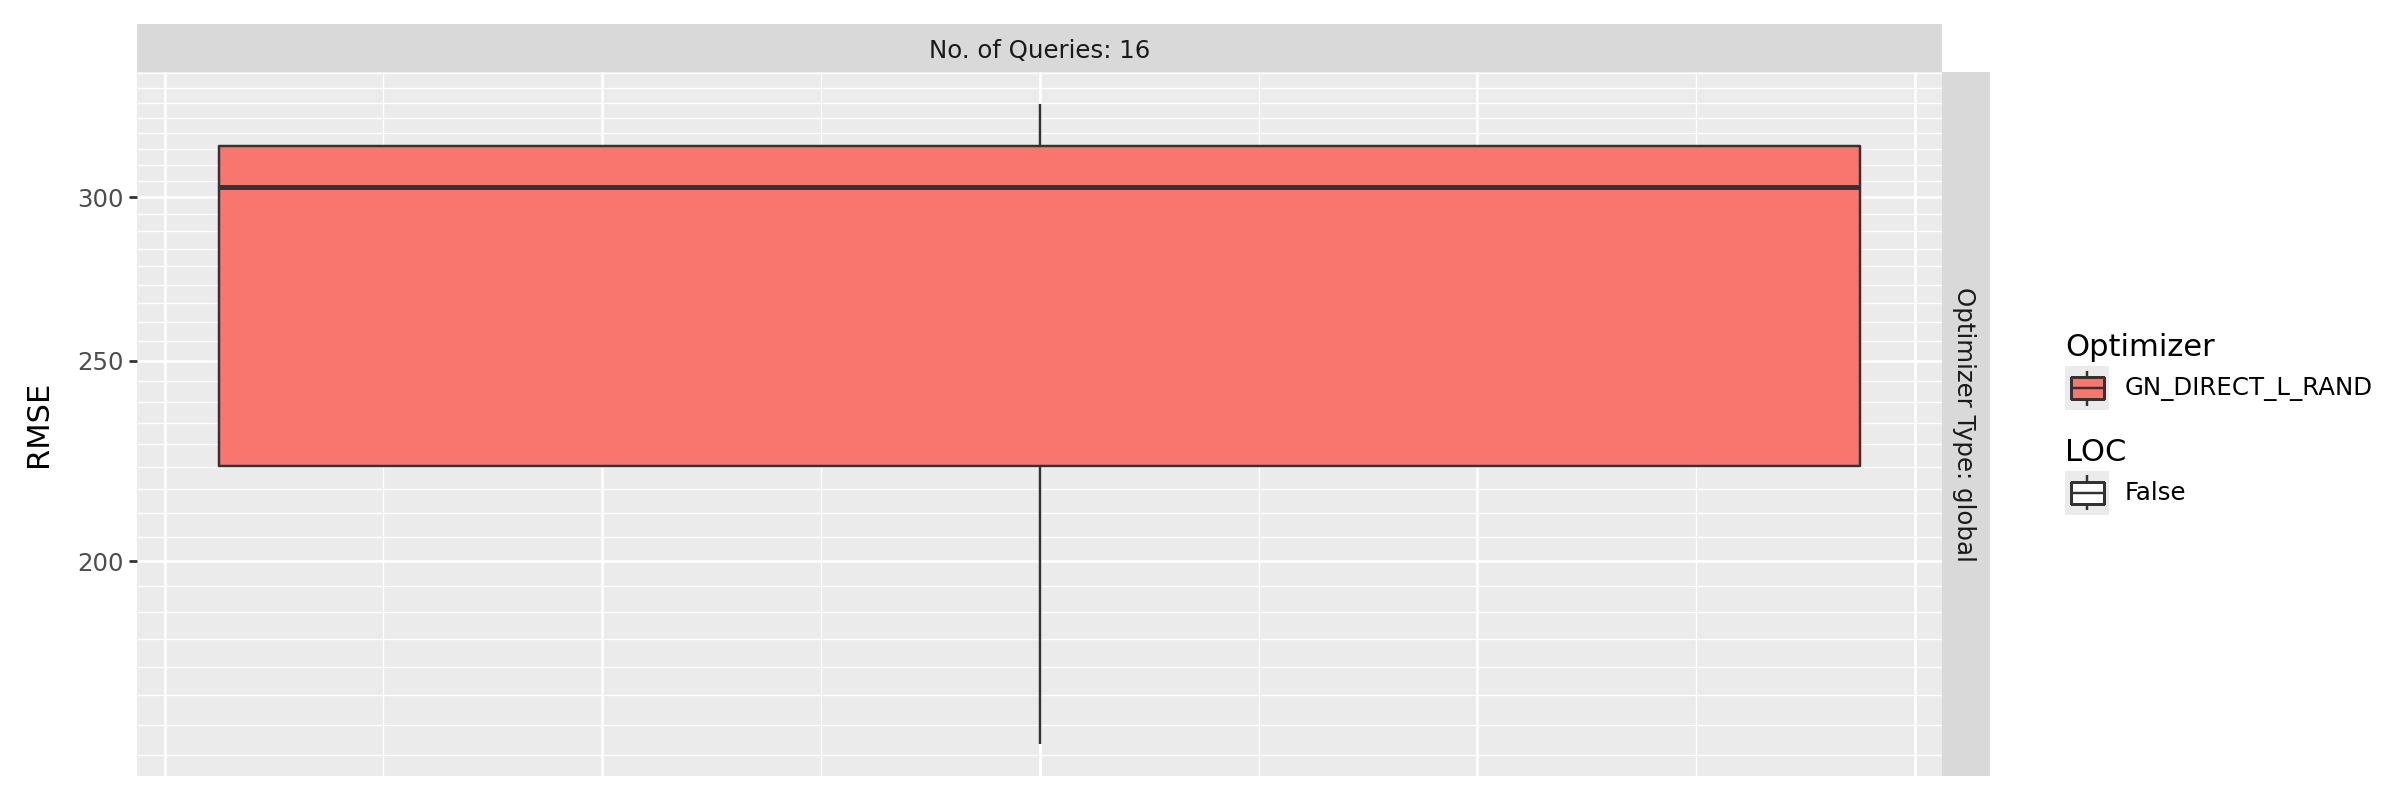

In [19]:
# x='Optimizer'
x=None
y='target_opt_final'
fill='Optimizer'
cols='No. of Queries'
rows='Optimizer Type'
linetype='LOC'
ylab = SS_MC_MERGED_WIDE['Error Function'][0] if y == 'target_opt_final' else y
p = (ggplot(SS_MC_MERGED_WIDE, aes(x=x, y=y, fill=fill, linetype=linetype))
     +geom_boxplot()
     +facet_grid(cols=cols, rows=rows, labeller='label_both')
     +theme(figure_size=(12, 4),
            axis_text_x=element_blank(),
            axis_ticks_x=element_blank(),)
     +scale_y_log10()
     +labs(y=ylab)
)
if not (SS_MC_MERGED_WIDE.groupby([fill, cols, rows, linetype])[y].count()==60).all():
    t = SS_MC_MERGED_WIDE.groupby([fill, cols, rows, linetype])[y].count()
    print(t[t!=60])
    # raise ValueError('not all boxplots have 60 values')
#p.save(fig_dir + f'/{y}_{selected_group_ids}.pdf')
p

In [ ]:
SS_MC_MERGED_WIDE[(SS_MC_MERGED_WIDE['Optimizer'] == 'GN_CRS2_LM') & (SS_MC_MERGED_WIDE['No. of Queries'] == 128 ) & (SS_MC_MERGED_WIDE['Optimizer Type'] == 'global') & (SS_MC_MERGED_WIDE['LOC'] == 'False' )]

## SS MC metrics: multiple metrics (MM) in one plot

In [ ]:
SS_MC_MERGED_MM = (SS_MC_MERGED_WIDE[SS_MC_MERGED_WIDE['Optimizer'].isin(['Random Search', 'GN_DIRECT_L_RAND', 'LN_PRAXIS'])]
     .set_index(PARAMS.columns.to_list()+['carrier'])[[
         '$d_{PHD}$',
         '$d_{MPHD}$',
         '$d_{J}$',
         # '$d_{THJD}$',
         # '$d_{TSP}$',
         '$d_{MinWBMP}$',
     ]]
     .melt(ignore_index=False)
     .reset_index()
)

In [ ]:
x='Optimizer'  # will not work if x=None
y='value'
fill = 'Optimizer'
linetype='LOC'
cols = 'No. of Queries'
rows='key'

p = (ggplot(
    SS_MC_MERGED_MM,
    aes(x=x,
        y=y,
        fill=fill,
        linetype=linetype
       ))
  + geom_boxplot()
 # + geom_violin(style='left')  # makes no sense, I have way to few data points
 # + geom_jitter(width=0.1)  # is just distracting
 + facet_grid(
     cols=cols,
     rows=rows,
     labeller='label_both',
     scales='free'
 )
 + theme(figure_size=(12, 6), 
         axis_text_x=element_blank(),
         axis_ticks_x=element_blank(),
         strip_text_y=element_blank(),
         strip_background_y=element_blank(),
         axis_title_y=element_text(margin={'r': 10}),
        )
 + labs(y="", x="")
 + coord_cartesian(ylim=(0, None))
)
p = p.draw(show=False)
axes = p.axes
row_variables = sorted(SS_MC_MERGED_MM['key'].unique())
num_cols = SS_MC_MERGED_MM[cols].nunique()

for i, var_name in enumerate(row_variables):
    ax_index = i * num_cols
    if ax_index < len(axes):
        axes[ax_index].set_ylabel(var_name)
        axes[ax_index].yaxis.set_label_coords(-0.2, 0.5)

if not (SS_MC_MERGED_MM.groupby([fill, cols, rows, linetype])[y].count()==60).all():
    t = SS_MC_MERGED_MM.groupby([fill, cols, rows, linetype])[y].count()
    print(t[t!=60])
    # raise ValueError('not all boxplots have 60 values')


plt.tight_layout()
p.savefig(fig_dir + f'/distances_{selected_group_ids}.pdf', bbox_inches='tight')
p

# Plots for multi-step metrics

In [ ]:
tmp_group_columns = ['step'] + [i for i in non_unique_params.columns if i != 'data__r']
tmp = MS_MERGED[non_unique_params.columns.to_list() + MS_METRICS.columns.to_list()]
tmp.loc[tmp['LOC'].isna(), 'LOC'] = 'False'
tmp = tmp.fillna(np.inf)  # First replace nan
tmp = tmp.groupby(
    tmp_group_columns,
    dropna=False)
tmp = tmp.mean(numeric_only=True).replace(np.inf, np.nan) # Then insert nan's again
tmp = tmp.reset_index()

#tmp['No. of Bidding Jobs'] = tmp['No. of Bidding Jobs'].astype(str)
px.line(
    tmp,
    x='step',
    y='target_opt__mean',
    color='Optimizer',
    facet_col='No. of Queries',
    facet_row='Optimizer Type',
    line_dash='LOC',
    #markers=True,
    #labels={'target_opt_mean': PARAMS['Error Function'].unique()[0]},
    log_y=True,
    height=800
).update_traces(connectgaps=True)

In [ ]:
p = (
    ggplot(tmp, aes(
        x='step',
        y='target_opt__mean',
        color='Optimizer',
        linetype='LOC'
    ))
    + geom_line()
    + facet_grid(
         cols='No. of Queries',
         rows='Optimizer Type',
         labeller='label_both'
     )
    # + geom_point()
    + labs(y=PARAMS['Error Function'].unique()[0], x='No. of function evaluations')
    + scale_y_log10()
    #+ theme_classic()
    + theme(figure_size=(12, 4))
    + scale_color_discrete()
)
# p.save(fig_dir + f'/convergence_{selected_group_ids}.pdf')
p

# Scratches